## Importing Dependencies - Run twice in case of deprecation error

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from EMS_Gym_Env import EMSGymEnv
from device_classes import Intermittent, Uninterruptible

from ray.rllib.algorithms.a2c import A2CConfig
from ray.tune.registry import register_env

## Setting up Prudent Custom Environment based on information found at : https://www.daftlogic.com/information-appliance-power-consumption.htm

In [8]:
# Assigning data file
data_file = "nyiso_hourly_prices_for_inference.csv"

# Creating the intermittent devices
intermittent_user_probabilities = np.array([0.20, 0.80, 0.90, 0.20])

intermittent_device_penalty = 100

intermittent_device_1 = Intermittent(name = "Small AC", device_power_consumption = 1, 
                                        user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

intermittent_device_2 = Intermittent(name = "Big AC", device_power_consumption = 2.5, 
                                    user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

intermittent_device_3 = Intermittent(name = "Ceiling Fan 1", device_power_consumption = 0.07,
                                    user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

intermittent_device_4 = Intermittent(name = "Ceiling Fan 2", device_power_consumption = 0.07,
                                    user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

intermitent_device_5 = Intermittent(name = "Boiler", device_power_consumption = 3,
                                    user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

intermittent_device_6 = Intermittent(name = "Dehumidifier", device_power_consumption = 0.07,
                                    user_probabilities = intermittent_user_probabilities, device_standard_penalty = intermittent_device_penalty)

array_of_intermittent_devices = [intermittent_device_1, intermittent_device_2, intermittent_device_3, intermittent_device_4, intermitent_device_5, intermittent_device_6]

# Creating the uninterruptible devices

uninterruptible_user_probabilities = np.array([0.20, 0.80, 0.90, 0.20])

uninterruptible_device_standard_penalty = 100

uninterruptible_device_override_penalty = 1000

uninterruptible_device_1 = Uninterruptible(name = "Dishwasher", device_power_consumption = 1.3,
                                            user_probabilities = uninterruptible_user_probabilities, device_standard_penalty = uninterruptible_device_standard_penalty, 
                                            device_on_duration = 2.5, device_override_penalty = uninterruptible_device_override_penalty)

uninterruptible_device_2 = Uninterruptible(name = "Washing Machine", device_power_consumption = 0.5,
                                            user_probabilities = uninterruptible_user_probabilities, device_standard_penalty = uninterruptible_device_standard_penalty, 
                                            device_on_duration = 1, device_override_penalty = uninterruptible_device_override_penalty)

uninterruptible_device_3 = Uninterruptible(name = "Clothes Dryer", device_power_consumption = 2.4,
                                            user_probabilities = uninterruptible_user_probabilities, device_standard_penalty = uninterruptible_device_standard_penalty, 
                                            device_on_duration = 0.5, device_override_penalty = uninterruptible_device_override_penalty)

array_of_uninterruptible_devices = [uninterruptible_device_1, uninterruptible_device_2, uninterruptible_device_3]

# Creating the environment
train_env = EMSGymEnv(data_file = data_file, intermittent_devices = array_of_intermittent_devices,
                uninterruptible_devices = array_of_uninterruptible_devices, episode_horizon = 1, time_step_duration = 0.5)

Environment successfully initialized


## Loading MARWIL Algorithm Checkpoint and Running it on a Random Day

2024-07-17 15:39:34,310	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2024-07-17 15:39:34,350	INFO trainable.py:791 -- Restored on 127.0.0.1 from checkpoint: prudent_environment_logs\A2C\penalties_100_100_1000\A2C_SmartHomeGymEnv_a860d_00000_0_2024-03-29_14-57-26\checkpoint_000158
2024-07-17 15:39:34,350	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 158, '_timesteps_total': None, '_time_total': 311.81944942474365, '_episodes_total': 158}


The mean reward for this episode was: -2608.144893619791


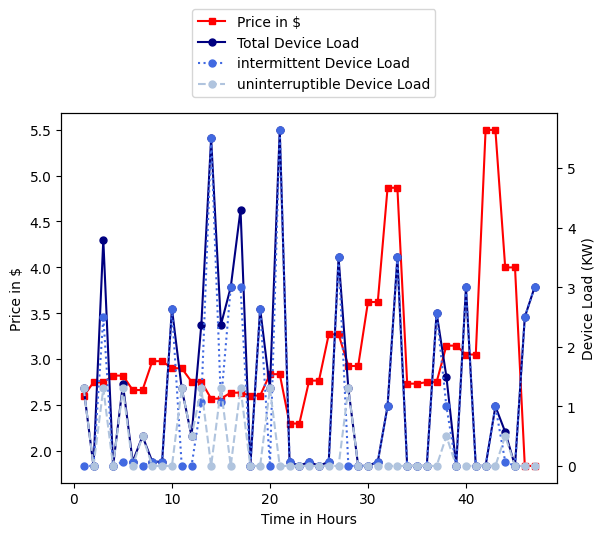

In [10]:
path = "prudent_environment_logs/A2C/penalties_100_100_1000/A2C_SmartHomeGymEnv_a860d_00000_0_2024-03-29_14-57-26/checkpoint_000158"

config = A2CConfig()
config = config.training(lr=0.001,train_batch_size=300)
config = config.environment(env="SmartHomeGymEnv")
config = config.rollouts(num_rollout_workers=0,batch_mode="complete_episodes",rollout_fragment_length=300,num_envs_per_worker = 1,)
config = config.framework(framework="tf2")#,eager_tracing=True)
config = config.resources(num_gpus=0, num_trainer_workers=1)
config.offline_data(postprocess_inputs=True)
env = train_env
register_env("SmartHomeGymEnv", lambda config: env)  
config = config.environment(env="SmartHomeGymEnv")
algorithm = config.build(env="SmartHomeGymEnv")
# Restore the algo's state from the checkpoint.
algorithm.restore(path)

env.reset()

# Setting json input with which the environment starts
obs = {'intermittent_devices' : [0,0,0,0,0,0], 'uninterruptible_devices' : [0,0,0], 'uninterruptible_devices_duration_countdown' : [0,0,0],
    'energy_price' : [2.0] , 'time' : [0]}

done = False
episode_reward = 0
counter = 0

# Calculate one episode
while not done:
    # Get action based on agent 
    action = algorithm.compute_single_action(obs)
    # Calculate next step
    obs, reward, done, truncated, info = env.step(action)

    episode_reward += reward
    counter +=1

print("The mean reward for this episode was: " + str(episode_reward/counter))

plot_time = info["time"]
plot_price = info["price_history"]
plot_kwh = info["kwh_device_history"]
plot_intermittent_kwh = info["kwh_intermittent_device_history"]
plot_uninterruptible_kwh = info["kwh_uninterruptible_device_history"]

window_size = 1
moving_average_plot_price = np.convolve(plot_price, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_kwh = np.convolve(plot_kwh, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_intermittent_kwh = np.convolve(plot_intermittent_kwh, np.ones(window_size)/window_size, mode='valid')
moving_average_plot_uninterruptible_kwh = np.convolve(plot_uninterruptible_kwh, np.ones(window_size)/window_size, mode='valid')

fig,ax1 = plt.subplots()

ax1.set_xlabel('Time in Hours')
ax1.set_ylabel('Price in $')
plot_1 = ax1.plot(plot_time[:47],moving_average_plot_price[:47],color='red', marker = 's', ms = 5)

ax2 = ax1.twinx()
ax2.set_ylabel('Device Load (KW)')
plot_2 = ax2.plot(plot_time[:47],moving_average_plot_kwh[:47],color='navy', marker = 'o', ms = 5)
plot_3 = ax2.plot(plot_time[:47],moving_average_plot_intermittent_kwh[:47],color='royalblue', marker = 'o', ms = 5,ls=':')
plot_4 = ax2.plot(plot_time[:47],moving_average_plot_uninterruptible_kwh[:47],color='lightsteelblue', marker = 'o', ms = 5,ls='--')

plt.legend(handles=[plot_1[0], plot_2[0], plot_3[0], plot_4[0]], labels=['Price in $', 'Total Device Load', 'intermittent Device Load' , 'uninterruptible Device Load'], loc='upper left',bbox_to_anchor=(0.25, 1.3))

plt.show()